## Mini Project 1
### Question 1

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch

%matplotlib inline

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


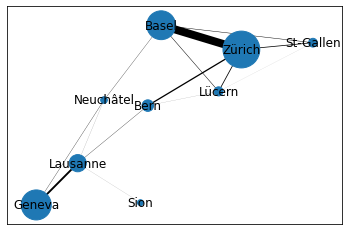

In [2]:
# load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml')
print(dyn.cities)
dyn.draw_map()

In [ ]:
def plot(log):
    """ Divide the log into the different cities and plot the infected and dead people for each city """
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    """ Plot the full state, the observable state and the actions"""
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

In [ ]:
def plot(log, action=True):
    """ Divide the log into the different cities and plot the infected and dead people for each city """
    total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    """ Plot the full state, the observable state and the actions"""
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2) if action else None
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if action:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

### Question 1

#### Question 1a

In [ ]:
# Create the environment
env = Env(dyn)

In [ ]:
# Requirement: Using the same sequence of random seeds.
seed = 42


unmitigated = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=seed)
while not finished:
    action = unmitigated
    obs, reward, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

In [ ]:
plot(log,action=False)

##  Question 2

In [ ]:
""" Implement the Pr. Russo's Policy in the form of python class"""
class Russo(Agent):
    def __init__(self, env):
        self.env = env
        self.confine_index = 0
    
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
        return 0
    
    def reset(self):
        self.confine_index = 0
    
    def act(self, obs):
        # If the action is not confinement, and infected people are more than 20000, then confine for 4 weeks
        if self.confine_index == 0 and obs.total.infected[-1] > 20000:
            self.confine_index = 4
            
        # Action for the weeks of confinement
        if self.confine_index > 0:
            self.confine_index -= 1
            confine_state = True
        else:
            confine_state = False

        action = {
            'confinement': confine_state,
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }
        
        return action
    


In [ ]:
env = Env(dyn)
agent = Russo(env)
seed = 42

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed=seed)
while not finished:
    action = agent.act(obs)
    obs, reward, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

In [ ]:
plot(log)

### Discussion
TODO

### Question 2b

In [ ]:
""" Evaluate the policy, save confined day, reward, and total death. For each episode, save the mentioned values"""
def evaluate(agent, env, episodes=50,seed=42):
    log_confine = []
    log_reward = []
    log_death = []

    # Run the episodes
    np.random.seed(seed)
    seed_sequence = np.random.randint(0, 1000, size=episodes)
    for i in range(episodes): 
        # Reset the episode
        episode_confine = 0
        episode_reward = 0
        episode_death = 0
        obs, info = env.reset(seed_sequence[i])
        agent.reset()

        # Run the episode
        finished = False
        while not finished:
            action = agent.act(obs)
            obs, reward, finished, info = env.step(action)
            episode_confine += 7 * int(info.action['confinement'])# weeks to 7 days
            episode_reward += float(reward) # reward is a tensor, convert it to float, or the figure cannot be plotted
            episode_death = int(info.total.dead)
            if finished:
                break

        # Save the episode
        log_confine.append(episode_confine)
        log_reward.append(episode_reward)
        log_death.append(episode_death)

    return log_confine, log_reward, log_death



In [ ]:
""" Plot via histogram """
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    ax.grid()

def plot_hist(log_confine, log_reward, log_death):
    fig, ax = plt.subplots(3,1,figsize=(15,12))
    hist_avg(ax[0],log_confine,'confinement days')
    hist_avg(ax[1],log_reward,'cumulative rewards')
    hist_avg(ax[2],log_death,'deaths')
    fig.tight_layout()
    plt.show()

In [ ]:
seed = 42
env = Env(dyn)
agent = Russo(env)

log_confine, log_reward, log_death = evaluate(agent, env, episodes=50,seed=seed)

In [ ]:
plot_hist(log_confine, log_reward, log_death)

"""Print example of the log"""
print(f'Average death: {np.mean(log_death)}')
print(f'Average reward: {np.mean(log_reward)}')
print(f'Average confined days: {np.mean(log_confine)}')

### Question 3

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import random
from collections import namedtuple, deque
from itertools import count
from gym import spaces
import torch

In [4]:
dyn = ModelDynamics('config/switzerland.yaml')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


sampled space: 1
Sampled observation


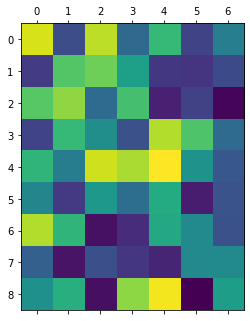

In [6]:
# Define the action space
action_space = spaces.Discrete(2) # 0: False, 1: True
observation_space = spaces.Box(low = 0,
                               high = 1,
                               shape = (2, dyn.n_cities,dyn.env_step_length),
                               dtype = np.float16)
print(f'sampled space: {action_space.sample()}')
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor,dyn: ModelDynamics):
    action = {
        'confinement': False,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True

    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]),0.25)
    dead = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]),0.25)
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)
    

In [7]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 3a

In [8]:
# build the network
class DQN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        hidden_size1 = 64
        hidden_size2 = 32
        hidden_size3 = 16

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = x.view(-1,self.input_size)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [9]:
def int_to_tensor(x, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    return torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


In [28]:
class DQNAgent(Agent): 

    def __init__(self, env:Env, batch_size: int =2048, 
                 lr:float = 5e-3, buffer_size: int = 20000,  gamma:float = 0.9, 
                 epsilon:float = 0.7, target_net = None,
                 device = device, policy_net = None, optimizer = None,
                 ):
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.policy_net = policy_net
        self.buffer_size = buffer_size
        self.memory_initial()
        self.env = env
        self.device = device
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    """ReplayMemory Part Put Here To Avoid Confusion"""
    def memory_initial(self):
        self.memory = deque([],maxlen= self.buffer_size)

    def memory_push(self, transition):
        self.memory.append(transition)

    def memory_sample(self,):
        return random.sample(self.memory, self.batch_size)
        
    def memory_len(self):
        return len(self.memory)
    
    """Agent Part"""
    def load_model(self, savepath):
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.model.state_dict())
        pass

    def save_model(self, savepath):
        torch.save(self.policy_net.state_dict(), savepath)
        pass



    def reset(self):
        pass

    def act(self, obs, epsilon_fixed): 
        # epsilon greedy
        if random.random() < epsilon_fixed:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            return self.policy_net(obs.to(self.device)).max(1)[1].view(1, 1)
            



    def optimize_model(self, train = True):
        if self.memory_len() < self.batch_size:
            return 0
        
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool).to(device)
        
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None]).to(device)
        
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()

        state_action_values = self.policy_net(state_batch).gather(1, action_batch).to(device)
        

        next_state_values = torch.zeros(self.batch_size, device=self.device)


        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_state).max(1)[0]

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Computer MSE loss
        criterion = nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss.item()

    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [29]:
def each_episode(env, agent, seed):
    state, _ = env.reset(seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state, 0.7)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss

    return total_reward.item(), total_loss


def each_evaluation(env, agent, seed):
    state, _ = env.reset(seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state, 0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss

    return total_reward.item(), total_loss


In [30]:
seed = 42
batch_size = 2048
lr = 5e-3
buffer_size = 20000
gamma = 0.9
input_size = 2 * dyn.n_cities * dyn.env_step_length

state, info = env.reset(seed)

# initialize policy network
policy_net = DQN(input_size,2).to(device)
target_net = DQN(input_size,2).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
dqnagent_3a = DQNAgent(env, gamma= gamma, epsilon= 0.7, policy_net = policy_net, target_net = target_net, device = device,optimizer=optimizer)

n_episodes = 500

In [31]:
def train_3a(training_loss_trace_path = None,training_rewards_trace_path=  None, eval_loss_trace_path = None, eval_rewards_trace_path = None,): 

    train_length:int = 500
    full_update: int = 5
    small_cycle: int = 50


    training_loss_trace = []
    training_rewards_trace = []
    eval_loss_trace = []
    eval_rewards_trace = []

    best_reward = -np.inf

    for i in range(1, train_length + 1):
        if i == 68: 
            print("pasuse")
        reward, loss = each_episode(env, dqnagent_3a, i)
        training_loss_trace.append(loss)
        training_rewards_trace.append(reward)
        print('Episode: ', i, '| Episode Reward: ', reward, '| Episode Loss: ', loss)
        if i % full_update == 0:
            # Fully update the target network every 5 episodes
            dqnagent_3a.update_target_model()
        
        if i % small_cycle == 0:
            eval_list = np.array([each_evaluation(env,dqnagent_3a,i) for _ in range(20)])
            eval_loss = np.mean(eval_list,axis = 0)[1]
            eval_reward = np.mean(eval_list,axis = 0)[0]

            eval_loss_trace.append(eval_loss)
            eval_rewards_trace.append(eval_reward)
            training_loss = np.mean(training_loss_trace[i-50:i-1])
            training_reward = np.mean(training_rewards_trace[i-50:i-1])

            if eval_reward > best_reward:
                best_reward = eval_reward
                torch.save(dqnagent_3a.policy_net.state_dict(), '3a_dqnagent_best.pth')
            # print episode i / training_length
            print(f'Episode {i} of {train_length}:train reward {training_reward:.2f}, train loss {training_loss:.4f}, eval reward {eval_reward:.2f},eval loss {eval_loss:.2f}')

    with open(training_loss_trace_path, 'w') as f:
        json.dump(training_loss_trace, f)
    with open(training_rewards_trace_path, 'w') as f:
        json.dump(training_rewards_trace, f)
    with open(eval_loss_trace_path, 'w') as f:
        json.dump(eval_loss_trace, f)
    with open(eval_rewards_trace_path, 'w') as f:
        json.dump(eval_rewards_trace, f)

In [32]:
train_3a()

Episode:  1 | Episode Reward:  -198.63919067382812 | Episode Loss:  0
Episode:  2 | Episode Reward:  -213.29391479492188 | Episode Loss:  0
Episode:  3 | Episode Reward:  -172.13829040527344 | Episode Loss:  0
Episode:  4 | Episode Reward:  -276.7890319824219 | Episode Loss:  0
Episode:  5 | Episode Reward:  -93.92024993896484 | Episode Loss:  0
Episode:  6 | Episode Reward:  -305.8403625488281 | Episode Loss:  0
Episode:  7 | Episode Reward:  -144.24319458007812 | Episode Loss:  0
Episode:  8 | Episode Reward:  -79.31829833984375 | Episode Loss:  0
Episode:  9 | Episode Reward:  -198.124755859375 | Episode Loss:  0
Episode:  10 | Episode Reward:  -132.19419860839844 | Episode Loss:  0
Episode:  11 | Episode Reward:  -127.28489685058594 | Episode Loss:  0
Episode:  12 | Episode Reward:  -138.8107147216797 | Episode Loss:  0
Episode:  13 | Episode Reward:  -115.83476257324219 | Episode Loss:  0
Episode:  14 | Episode Reward:  -151.30810546875 | Episode Loss:  0
Episode:  15 | Episode Re

KeyboardInterrupt: 

In [ ]:
n_experiments = 3
training_loss_trace_combine = []
training_rewards_trace_combine = []
eval_loss_trace_combine = []
eval_rewards_trace_combine = []


for i in range(n_experiments):

    dqnagent_3a = DQNAgent(env, gamma = gamma, policy_net = policy_net, target_net = target_net, optimizer = optimizer, device = device, epsilon=0.7)



    print(f'=====================================Experiment {i+1} of {n_experiments}================================')
    train_3a(training_loss_trace_path = f'./model_storage/3a_training_loss_trace_{i}.json',training_rewards_trace_path= f'./model_storage/3a_training_rewards_trace_{i}.json', eval_loss_trace_path = f'./model_storage/3a_eval_loss_trace_{i}.json', eval_rewards_trace_path = f'./model_storage/3a_eval_rewards_trace_{i}.json',)
print("=====================================Experiment Done================================")

In [ ]:
# average the three experiments
def plot_trace():
    

    # import training and eval rewards trace from json
    training_rewards_trace_combine = []
    evaluation_rewards_trace_combine = []

    for i in range(3):
        with open(f'3a_training_rewards_trace_{i}.json', 'r') as f:
            training_rewards_trace_combine.append(json.load(f))
        with open(f'3a_eval_rewards_trace_{i}.json', 'r') as f:
            evaluation_rewards_trace_combine.append(json.load(f))

    small_cycle = 50
    training_episode = np.arange(1,len(training_rewards_trace_combine[0])+1)
    training_episodes = np.stack(training_episode for _  in range(len(training_loss_trace_combine)) )
    training_rewards_trace_combine = np.array(training_rewards_trace_combine)
    plt.scatter(training_episodes, training_rewards_trace_combine, s = 1, c = 'b', label = 'training')

    evaluation_episode = np.arange(0,len(training_rewards_trace_combine[0]),small_cycle) + small_cycle
    eva
                                   


    